<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/240721_gbif_pitta_nympha_data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %pip install -q geemap==0.33.1

In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-foss4g')

In [2]:
import geemap
import os, requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
def get_gbif_species_data(species_name, country_code):
    """
    Retrieves observational data for a specific species using the GBIF API and returns it as a pandas DataFrame.

    Parameters:
    species_name (str): The scientific name of the species to query.
    country_code (str): The country code of the where the observation data will be queried.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the observational data.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an exception for a response error.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # If data is present
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # Returns an empty DataFrame
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Returns an empty DataFrame in case of an exception

In [ ]:
# Retrieve Fairy Pitta data
df = get_gbif_species_data("Pitta nympha", "KR")

# Save DataFrame to CSV and read back in.
df.to_csv("pitta_nympha_raw.csv", index=False)
df = pd.read_csv("pitta_nympha_raw.csv")

df.head(1)  # Display the first row of the DataFrame

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4875314160,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-07-09T01:59:58.897+00:00,2024-07-09T17:15:20.708+00:00,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]

# Convert GeoDataFrame to GeoPackage (requires pycrs module)
%pip install -U -q pycrs
gdf.to_file("pitta_nympha_raw.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_raw.gpkg")

gdf.head(1)  # Display the first row of the GeoDataFrame

,species,year,month,geometry
0,Pitta nympha,2024,6,POINT (126.93219 35.41408)


In [ ]:
from google.colab import files

files.download('pitta_nympha_raw.csv')
files.download('pitta_nympha_raw.gpkg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Yearly and monthly data distribution heatmap
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # Heatmap
    plt.figure(figsize=(h_size, h_size - 6))
    heatmap = plt.imshow(
        statistics.values, cmap="YlOrBr", origin="upper", aspect="auto"
    )

    # Display values above each pixel
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(
                j, i, statistics.values[i, j], ha="center", va="center", color="black"
            )

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig("heatmap_plot.png")
    plt.show()

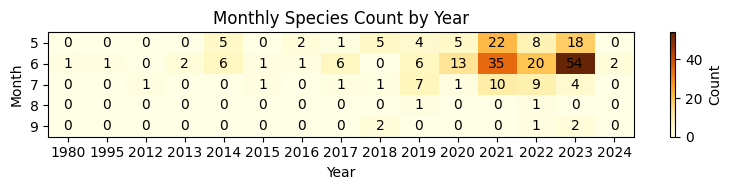

In [ ]:
plot_heatmap(gdf)

### 선택한 데이터 범위와 그 이유

본 연구에서는 팔색조(Pitta nympha)의 서식지를 예측하기 위해 최근 5년간의 대한민국 지역 내 출현 데이터를 사용하였다. 구체적으로는 2019년부터 2023년까지, 5월부터 7월 사이의 데이터를 한정적으로 분석하였다. 이는 팔색조가 여름철에 주로 서식지를 이동하는 철새로서, 계절적 패턴을 반영하는 데이터가 필요하기 때문이다.

최근 5년간의 데이터를 사용하는 이유는 다음과 같다. 첫째, 최신 데이터는 현재의 환경 조건과 생태적 변화를 가장 잘 반영한다. 기후 변화와 인류 활동에 따른 환경 변화가 빠르게 진행되고 있는 상황에서 최신 데이터를 사용하는 것은 서식지 예측 모델의 정확성을 높이는 데 필수적이다. 특히, 팔색조는 환경 변화에 민감하게 반응하는 종으로, 최신 데이터를 통해 보다 정확한 예측을 할 수 있다.

또한, 팔색조는 여름철에 활발히 활동하는 철새로서 5월부터 7월 사이의 데이터는 이들의 이동 및 서식지 선택 패턴을 가장 잘 반영할 수 있다. 따라서, 이 기간 동안의 데이터를 사용함으로써 팔색조의 실제 서식지와 이동 경로를 정확하게 모델링할 수 있다.

In [ ]:
# Filtering data by year and month
gdf_filtered1 = gdf[
    (gdf['year'].between(2019, 2023)) &
    (gdf['month'].between(5, 7))
]

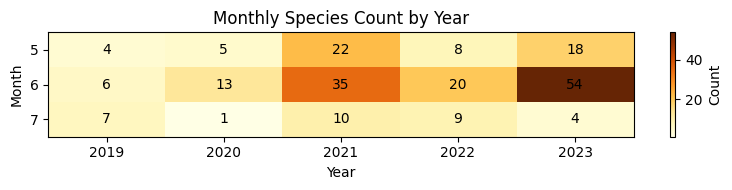

In [ ]:
plot_heatmap(gdf_filtered1)

In [ ]:
# 개수 출력
gdf_count = len(gdf)
print(f'gdf의 개수: {gdf_count}')

gdf_filtered1_count = len(gdf_filtered1)
print(f'필터링된 gdf_filtered1의 개수: {gdf_filtered1_count}')

gdf의 개수: 260
필터링된 gdf_filtered1의 개수: 216


In [ ]:
gdf_filtered1.to_file("pitta_nympha_filtered1.gpkg", driver="GPKG")
files.download('pitta_nympha_filtered1.gpkg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# 대한민국 범위 좌표 지정 (좌하단 및 우상단 좌표)
rectangle_coords = [
    [125.0765578311698505, 33.1124998462386841],
    [131.8727812628718254, 38.4000004985049159],
]

# 직사각형 생성
rectangle = ee.Geometry.Rectangle(rectangle_coords)

# 직사각형을 Feature로 변환
feature = ee.Feature(rectangle)

# FeatureCollection 생성
kr = ee.FeatureCollection([feature])

m = geemap.Map(layout={'height':'400px', 'width':'800px'})
m.addLayer(kr, {}, "Republic of Korea")
m.centerObject(kr, 6)
m

Map(center=[35.77459004930308, 128.47466954702085], controls=(WidgetControl(options=['position', 'transparent_…

In [25]:
# 날짜 범위 설정
start_date = '2019-05-01'
end_date = '2023-07-31'

# Dynamic World 이미지 컬렉션 필터링
dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
      .filterDate(start_date, end_date)
      .filterBounds(kr.geometry()))

In [26]:
# ImageCollection의 이미지 개수
layer_count = dw.size().getInfo()
print(f'dw의 레이어 수: {layer_count}')

dw의 레이어 수: 15440


In [27]:
# 5월부터 7월까지 이미지 필터링
dw_filtered = dw.filter(ee.Filter.calendarRange(5, 7, 'month'))

# ImageCollection의 이미지 개수
layer_count = dw_filtered.size().getInfo()
print(f'dw의 레이어 수: {layer_count}')

dw의 레이어 수: 3851


In [28]:
# Dynamic World 이미지 컬렉션의 'label' 밴드 선택
classification = dw.select('label')

# 'mode' 리듀서를 사용하여 합성 이미지 생성
dw_composite = classification.reduce(ee.Reducer.mode())

In [29]:
# 시각화 매개변수 설정
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635',
        '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# 합성 이미지를 지리적 범위로 자르기
dw_composite_clipped = dw_composite.clip(kr.geometry())

m = geemap.Map(layout={'height':'400px', 'width':'800px'})
m.addLayer(dw_composite_clipped, dw_vis_params, 'Classified Composite')
m.centerObject(dw_composite_clipped, 9)
m

Map(center=[35.77459004930308, 128.47466954702085], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=dw_composite_clipped,
    description='DW_2019-2023_MAY-JUL',
    folder='kari-sdm',
    scale=10,  # 이미지의 해상도
    region=kr.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(30)  # 30초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: READY
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Status: RUNNING
Polling for task (id: NXWFLJAJ75JL4PB7R46KNRRU). Sta

In [3]:
!wget https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_filtered2.gpkg -O pitta_nympha_filtered2.gpkg

--2024-07-24 11:11:04--  https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_filtered2.gpkg
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_filtered2.gpkg [following]
--2024-07-24 11:11:04--  https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_filtered2.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122880 (120K) [application/octet-stream]
Saving to: ‘pitta_nympha_filtered2.gpkg’

pitta_nympha_filter 100%[===================>] 120.00K  --.-KB/s    in 0.02s   

2024-07-24 11:11:05 (7.28 MB/s) - ‘pitta_nympha_filtered2.gpkg’ saved [12

In [4]:
gdf = gpd.read_file('pitta_nympha_filtered2.gpkg')
gdf.head(1)

,species,year,month,DW_1,geometry
0,Pitta nympha,2023,5,0.0,POINT (126.72514 33.20314)


In [5]:
# Calculating the count and percentage of each unique value in the DW_1 field
dw1_counts = gdf['DW_1'].value_counts().sort_index()
dw1_percentages = gdf['DW_1'].value_counts(normalize=True).sort_index() * 100

# Creating a DataFrame for the results
results = pd.DataFrame({
    'Count': dw1_counts,
    'Percentage': dw1_percentages
})

# Display the results
print(results)

      Count  Percentage
DW_1                   
0.0      18    8.530806
1.0     137   64.928910
4.0      12    5.687204
6.0      44   20.853081


In [13]:
# Mapping the unique DW_1 values to the corresponding labels and colors
label_map = {0.0: 'Water', 1.0: 'Trees', 2.0: 'Grass', 3.0: 'Flood vegetation', 4.0: 'Crops',
             5.0: 'Shrub & Scrub', 6.0: 'Built Area', 7.0: 'Bare ground', 8.0: 'Snow & Ice'}
color_map = {0.0: '#419BDF', 1.0: '#397D49', 2.0: '#88B053', 3.0: '#7A87C6', 4.0: '#E49635',
             5.0: '#DFC35A', 6.0: '#C4281B', 7.0: '#A59B8F', 8.0: '#B39FE1'}

# Filtering the results to include only the labels that are present in the data
present_labels = [label_map[key] for key in results.index if key in label_map]
present_colors = [color_map[key] for key in results.index if key in color_map]

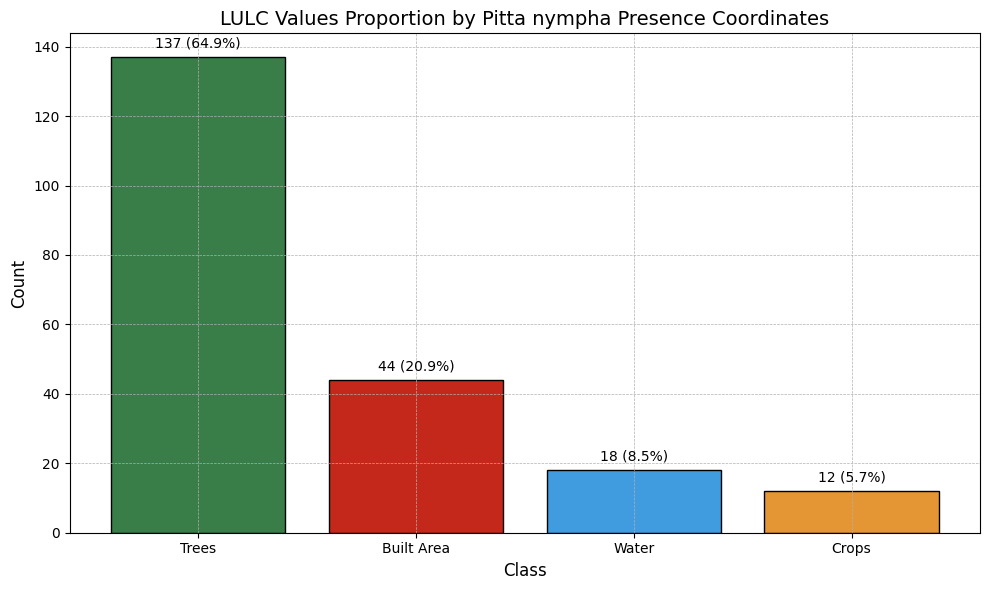

In [23]:
# Create a bar chart with counts and percentages
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for the counts
bars = ax.bar(present_labels, results['Count'], color=present_colors, edgecolor='black')

# Adding labels and title
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('LULC Values Proportion by Pitta nympha Presence Coordinates', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding count and percentage labels on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = results.iloc[i]['Percentage']
    ax.annotate(f'{height} ({percentage:.1f}%)',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Dynamic World의 토지 이용 및 토지 피복(Land Use and Land Cover, LULC)은 총 9개의 분류 클래스로 구성되어 있다. 본 연구에서는 GBIF(Global Biodiversity Information Facility)를 통해 수집된 각 출현 데이터 위치에 해당하는 LULC 정보를 수집하였다. 수집된 데이터 중 Trees, Grass, Flooded vegetation, Shrub & Scrub의 4개 클래스에 해당하는 좌표는 Presence 좌표로 채택하였으며 Crops, Built Area, Bare ground 클래스에서는 Absence 좌표를 샘플링하였다. Water와 Snow & Ice 클래스는 분석 대상에서 제외하였다.

In [21]:
# Selecting data where DW_1 value is 1 (Trees)
presence = gdf[gdf['DW_1'] == 1]
presence.head(1)

,species,year,month,DW_1,geometry
4,Pitta nympha,2023,5,1.0,POINT (126.69344 33.36925)


In [31]:
# Get the list of bands (layers) in the image.
bands = dw_composite_clipped.bandNames()
print('Bands:', bands.getInfo())

Bands: ['label_mode']


In [32]:
# Get the band 'label_mode'.
label_mode = dw_composite_clipped.select('label_mode')

# Create a mask for values 4, 6, 7.
mask = label_mode.eq(4).Or(label_mode.eq(6)).Or(label_mode.eq(7))

# Apply the mask to the image.
filtered_image = dw_composite_clipped.updateMask(mask)

m = geemap.Map(layout={'height':'400px', 'width':'800px'})
m.addLayer(filtered_image, {}, 'Pseudo-absence area')
m.centerObject(filtered_image, 9)
m

Map(center=[35.77459004930308, 128.47466954702085], controls=(WidgetControl(options=['position', 'transparent_…